In [1]:
import sys
import numpy as np
from scipy.stats import multivariate_normal
import signal
import torch
import re
from torch.distributions.multivariate_normal import MultivariateNormal
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../SOGA-main/src')
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

torch.set_default_dtype(torch.float64)

In [3]:
def preprocess_program(program):
    p = convert_and_normalize_gm_structure(program)
    p = convert_uniform_structure(p)
    return p


def convert_and_normalize_gm_structure(text):
    # Regular expression to find gm structure
    pattern = r'gm\(\s*(\[[^\]]+\](?:,\s*\[[^\]]+\])*)\s*\)'
    
    # Match all occurrences of the structure
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        # Find all sets of [pi, mu, s] inside the matched string
        elements = re.findall(r'\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]', match)
        
        # Separate pi, mu, and s into their own lists
        pi_list = [float(e[0]) for e in elements]
        mu_list = [e[1] for e in elements]
        s_list = [e[2] for e in elements]
        
        # Normalize pi_list
        pi_sum = sum(pi_list)
        normalized_pi_list = [pi / pi_sum for pi in pi_list] if pi_sum != 0 else pi_list
        
        # Format the new gm structure with normalized pi_list
        new_gm = f'gm([{", ".join(f"{pi:.6f}" for pi in normalized_pi_list)}], [{", ".join(mu_list)}], [{", ".join(s_list)}])'
        
        # Replace the old structure with the new one in the text
        converted_text = converted_text.replace(f'gm({match})', new_gm)
    
    return converted_text

def convert_uniform_structure(text):
    # Regular expression to find the structure uniform([a, b], c)
    pattern = r'uniform\(\s*\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]\s*,\s*([0-9.-]+)\s*\)'
    
    # Find all matches of uniform([a, b], c)
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        a = float(match[0])  # Extract 'a'
        b = float(match[1])  # Extract 'b'
        c = match[2]         # Extract 'c'
        
        # New value for 'a + b'
        new_b = a + b
        
        # Format the new uniform structure
        new_uniform = f'uniform([{a:.6f}, {new_b:.6f}], {c})'
        
        # Replace the old structure with the new one in the text
        old_uniform = f'uniform([{match[0]}, {match[1]}], {match[2]})'
        converted_text = converted_text.replace(old_uniform, new_uniform)
    
    return converted_text

In [4]:
def smooth_program(program_text):
    """
    Finds and modifies assignment lines where the variable is a letter or alphanumeric
    and the right-hand side does not contain 'gm' or 'uniform'.
    
    Args:
        program_text (str): The text of the program to analyze and modify.
    
    Returns:
        str: The modified program text.
    """
    # Define the regex pattern to identify assignments
    pattern = r'^(\s*([a-zA-Z]\w*)\s*=\s*([^;]*))(;?)'
    
    # Split the program into lines
    lines = program_text.splitlines()
    modified_lines = []
    
    for line in lines:
        match = re.match(pattern, line)
        if match:
            full_assignment, var, expression, semicolon = match.groups()
            # Check if 'gm' or 'uniform' is in the expression
            if 'gm' not in expression and 'uniform' not in expression:
                # Modify the assignment
                modified_assignment = f"{full_assignment} + gauss(0., 0.05){semicolon}"
                modified_lines.append(modified_assignment)
            else:
                # Keep the original line
                modified_lines.append(line)
        else:
            # Keep non-matching lines unchanged
            modified_lines.append(line)
    
    # Join the lines back into a single text
    return '\n'.join(modified_lines)   

In [5]:
#data_var_list = ['a', 'b']

#EXPERIMENT 1
#data = [[np.random.normal(1, 2), np.random.normal(8, 1)] for _ in range(5000)]
#EXPERIMENT 2
'''
data = []
for _ in range(5000):
    a = np.random.normal(1, 2)
    if a < 0:
        b = a * 3
    else: 
        b = np.random.normal(8, 1)
    data.append([a, b])
'''
#TRUESKILLS
data_var_list = ['skillA', 'skillB', 'skillC','rA', 'rB', 'rC']
#'perfA', 'perfB', 'perfC'
data = []
for _ in range(10000):
    rA = 0
    rB = 0
    rC = 0
    skillA = np.random.normal(100, 10)
    skillB = np.random.normal(100, 10)
    skillC = np.random.normal(100, 10)
    perfA = np.random.normal(0, 15) + skillA
    perfB = np.random.normal(0, 15) + skillB
    perfC = np.random.normal(0, 15) + skillC
    if perfA > perfB:
        rA = 1.0
    if perfB > perfC:
        rB = 1.0
    if perfA > perfC:
        rC = 1.0
    data.append([skillA, skillB, skillC, rA, rB, rC])

#MOG1
data_var_list = ['mu', 'sigma', 'x']
data = []
for _ in range(5000):
    mu = np.random.normal(20, 3)
    sigma = np.random.normal(2, 1)
    x = mu + sigma * np.random.normal(1, 1)
    data.append([mu, sigma, x])

In [6]:
#EXPERIMENT 1
#text_baseline = 'a = gm([1, 1, 2]);\nb = gm([1, 8, 1]);'
#text= 'a = uniform([-3, 3], 1);b = uniform([7, 2], 1);'
#text = 'a = gm([1, 1, 2]);b = gm([1, 8, 21]);'
#text = 'a = 8 * uniform([7.000000, 8.800000], 1);\nb = gm([0.264706, 0.735294, 1], [5, 1, 1.4], [1, 8.0, 9.0]) * uniform([2.000000, 9.200000], 6);'
#text = 'b = 6  * e + uniform([3, 7], 1);\nc = 4 * 7;\nc = 5 * gm([0, 6.0, 6], [4, 5, 0]);\nd = 3 - 9;\na = gm([5.7, 0, 0.5]) * gm([8.4, 1.1, 4]);'
#text = 'b = gm([1, 9, 2], [0, 6, 4.5])  - c;\na = gm([6, 1, 2.0]);'

#EXPERIMENT 1 GECCO
#text = 'b = gm([1, 9, 2], [0, 6, 4.5])  - c;\na = gm([6, 1, 2.0]);'


#EXPERIMENT 2
#text = ' a = uniform([5, 7], 1)  - 7;\nb = 1 * gm([9, 8.4, 2], [7, 0, 6]);'
#text = 'a = 9  * a + uniform([0, 7], 1);\nb = gm([8.4, 4.3, 8], [8.1, 9.9, 7])  - 1;'
#text = 'b = e + gm([0.4, 8.8, 1.4], [6, 6.6, 6.4]);\na = gm([1.0, 0.3, 8.0], [3, 5, 1.5]) * uniform([0, 1], 4);'
#text = 'a = uniform([0, 5.1], 1); \nb = 1 * gm([2, 0, 6.3], [2.8, 8, 0.9]);'
#text = ' a = 4 * uniform([0, 3], 2);\nif b <= 5 { \n    b = 3 * gm([8.4, 0.7, 2.4]);    \n} else {   \na = 7 + 9; \n} end if;'

#EXPERIMENT 2 HOLES
#text= 'a = gm([4.0, 1.5, 2.3]) ; \nb = gm([2.5, 0, 9], [5.2, 7.1, 2]);\nif a < 0 {\n    b = uniform([0, 1], 3)  - gm([9.8, 5, 6], [4, 4, 1.0]); \n} else { \n   e = gm([0.9, 5, 6], [3.4, 5, 5], [4.7, 2, 1.6]) * uniform([5, 9.4], 1); \n} end if;'
#text = 'a = gm([6.1, 1, 2]) ; \nb = gm([6.8, 8.1, 1.0]); \nif a < 0 { \n   b = 3 * a; \n} else { \n   c =2* b; \n} end if;'
#text = 'a = gm([2, 0.8, 2]) ; \nb = gm([8, 8, 1]); '# \nif a < 0 { \n  b = 5  - gm([2, 9.5, 5], [5, 8, 2.0]); \n} else { \n    d = gm([6.1, 5, 9.6], [2.4, 4.8, 3.2]) * gm([2.1, 5, 4]); \n} end if;'
#text_baseline = 'a = gm([1, 1, 2]);\nif a < 0 {\n  b = 3*a;\n} else{ \n  b = gm([1, 8, 1]);\n} end if;'

#TRUESKILLS
#text = 'skillA = 52  * gm([20, 61.5, 51.2], [70, 70.8, 0.9])  - 94 * 61; \nskillB = 22  * gm([0, 8, 22], [100, 3, 27.1])  - gm([76.8, 59, 5], [1.1, 91.4, 5.1]); \nskillC = 6  * skillB  - skillB; \nrA = 66 * 51 + 16 * 64;\nskillA = 49 * 2 - 17;\nrA = 55  * skillB + skillC;\nskillC = 8 - 1 * 8;\nrC = rB;'
#text_baseline = 'skillA = gauss(100, 10); \nskillB = gauss(100, 10); \nskillC = gauss(100, 10); \nperfA = gauss(0, 15 )+ skillA;\nperfB = gauss(0, 15 )+ skillB;\nperfC = gauss(0, 15 )+ skillC;\nif perfA - perfB > 0 {  \n  rA = gauss(1, 0.1);\n} else {\nrA = gauss(0, 0.1);\n } end if;\nif perfB - perfC > 0 {\n    rB = gauss(1, 0.1); \n } else {\n   rB = gauss(0, 0.1);\n } end if;\nif perfA - perfC > 0 {\n   rC = gauss(1, 0.1);\n } else {\n    rC = gauss(0, 0.1); \n} end if;'
#text = 'skillA = gauss(100, 10); \nskillB = gauss(100, 10); \nskillC = gauss(100, 10); \nperfA = gauss(0, 15 );\nperfB = gauss(0, 15 );\nperfC = gauss(0, 15 );\nif perfA - perfB > 0 {  \n  rA = gauss(1, 0.1);\n} else {\nrA = gauss(0, 0.1);\n } end if;\nif perfB - perfC > 0 {\n    rB = gauss(1, 0.1); \n } else {\n   rB = gauss(0, 0.1);\n } end if;\nif perfA - perfC > 0 {\n   rC = gauss(1, 0.1);\n } else {\n    rC = gauss(0, 0.1); \n} end if;'

#text_baseline = 'skillA = gauss(100, 10); \nskillB = gauss(100, 10); \nskillC = gauss(100, 10); \nperfA = gauss(0, 15 )+ skillA;\nperfB = gauss(0, 15 )+ skillB;\nperfC = gauss(0, 15 )+ skillC;\nif perfA - perfB > 0 {  \n  rA = 1;\n} else {\nrA = 0;\n } end if;\nif perfB - perfC > 0 {\n    rB = 1; \n } else {\n   rB = 0;\n } end if;\nif perfA - perfC > 0 {\n   rC = 1;\n } else {\n    rC = 0; \n} end if;'
#text = 'skillA = gauss(100, 10); \nskillB = gauss(100, 10); \nskillC = gauss(100, 10); \nperfA = gauss(0, 18.03 );\nperfB = gauss(0, 18.03 );\nperfC = gauss(0, 18.03 );\nif perfA - perfB > 0 {  \n  rA = 1;\n} else {\nrA = 0;\n } end if;\nif perfB - perfC > 0 {\n    rB = 1; \n } else {\n   rB = 0;\n } end if;\nif perfA - perfC > 0 {\n   rC = 1;\n } else {\n    rC = 0; \n} end if;'

#text = 'skillA = 24  * gm([86.5, 5, 57])  - uniform([12, 1], 4); \nskillB = 57 + 39  * rC; \nskillC = 93; \nrA = 67;\nrA = 45;\nrB = rA;\nskillA = 16  * skillA  - 82 * 20;'
#text = 'skillA = gm([90, 93.2, 7.9], [21.7, 96, 30.6]) + rC; \nskillB = 94 + 1  * gm([0.1, 5, 14]); \nskillC = 22  * uniform([3, 3], 1) + skillC; \nperfA = skillA + 42 + 57  * gm([85.1, 48, 65]); \nperfB = skillB + 59  * gm([71, 60.5, 36])  - 72  * gm([10.3, 51.4, 78.6]); \nperfC = skillC + 48 * 56 - 47; \nrB = 74 * 22;\nif perfA - perfB > 0 {  \n  rA = gauss(1, 0.1);\n} else {\nrA = gauss(0, 0.1);\n } end if;\nif perfB - perfC > 0 {\n    rB = gauss(1, 0.1); \n } else {\n   rB = gauss(0, 0.1);\n } end if;\nif perfA - perfC > 0 {\n   rC = gauss(1, 0.1);\n } else {\n    rC = gauss(0, 0.1); \n} end if;'

#MOG1

#text = 'mu = 83  * gm([7.9, 15, 48], [83, 97.4, 92.3], [75.1, 9.6, 97], [20.2, 11, 8], [6, 38.2, 61.9], [61.2, 36, 99.9], [93, 11, 8])  - mu; \nsigma = 22  * gm([78.5, 81.4, 14])  - 97  * mu; \nx = 86  * sigma  - gm([82.2, 93.2, 67], [29.1, 74.1, 84]);'
text = 'sigma = uniform([82, 8.7], 3)  - 23  * uniform([3, 1], 3);\nx = gm([5, 21.8, 7], [92.4, 21.7, 4], [15, 28, 15]);\nmu = 80  * gm([79.8, 42.9, 0], [6.1, 63, 33]) + mu;'
text_baseline = 'mu = gm([1, 20, 3]);\nsigma = gm([1,2,1]);\nx = sigma * gm([1,1,1]);\nx = x + mu;'
text = 'mu = 14 + 45;\nx = 5  * uniform([59, 2], 4)  - 6  * gm([5, 39, 16], [87, 47, 2.1], [35, 6.5, 96]);\nsigma = 4  * gm([3.3, 65.3, 65.3], [8.3, 100.2, 73], [88, 0.2, 12.1], [20, 78.5, 74.7]) + 3  * x;\nmu = gm([61, 26, 5.4])  - sigma;'
text = 'mu = uniform([0, 5.4], 3) + 16; \n sigma = x + 2  * uniform([0, 1.2], 1); \n x = uniform([28, 13.8], 3)  - 29 * 0; \n x = gm([9, 23, 1])  - 5  * sigma;'
text_baseline = preprocess_program(text_baseline)
text = preprocess_program(text)

#text = smooth_program(text)
#text_baseline = smooth_program(text_baseline)

#print(text_baseline)
print(text)
compiledText=compile2SOGA_text(text)
compiledText_baseline=compile2SOGA_text(text_baseline)

cfg = produce_cfg_text(compiledText)
cfg_baseline = produce_cfg_text(compiledText_baseline)


output_dist = start_SOGA(cfg)
output_dist_baseline = start_SOGA(cfg_baseline)

mu = uniform([0.000000, 5.400000], 3) + 16; 
 sigma = x + 2  * uniform([0.000000, 1.200000], 1); 
 x = uniform([28.000000, 41.800000], 3)  - 29 * 0; 
 x = gm([1.000000], [23], [1])  - 5  * sigma;


In [7]:
# Define a custom exception for timeouts
class TimeoutException(Exception):
    pass

# Define a handler function for the timeout
def handler(signum, frame):
    raise TimeoutException("Code execution exceeded time limit")


def compute_likelihood2(output_dist):
    likelihood = np.zeros(len(data))
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    marginal_means_components = []
    marginal_covariance_matrices_components = []
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        marginal_covariance_matrix = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix.append(output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)])
        marginal_means_components.append(marginal_means)
        marginal_covariance_matrices_components.append(marginal_covariance_matrix)

    for j in range(len(data)):
        for i in range(output_dist.gm.n_comp()):
            likelihood[j] = likelihood[j] + output_dist.gm.pi[i] * multivariate_normal.pdf(data[j], mean = marginal_means_components[i], cov = marginal_covariance_matrices_components[i][0], allow_singular=True)

        likelihood[j] = np.log(likelihood[j])
        #log_total_likelihood = log_total_likelihood + np.log(likelihood[j])
    sum_likelihood = np.sum(likelihood)
    #fitness = log_total_likelihood
    fitness = sum_likelihood/len(data)
    return fitness, likelihood

# Main code
try:
    # Set the timeout handler to raise TimeoutException after 5 seconds
    #signal.signal(signal.SIGALRM, handler)
    #signal.alarm(5)  # Set the timeout to 5 seconds
    fitness,l1 = compute_likelihood2(output_dist)
    fitness_baseline, l1 = compute_likelihood2(output_dist_baseline)

    # Cancel the alarm if the code completes within the time limit
    #signal.alarm(0)

except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
print(fitness_baseline)

-8.301564490888586
-6.19408434720645


In [7]:

def compute_likelihood_torch(output_dist):
    #dependencies = {'perfA': ['skillA'], 'perfB': ['skillB'], 'perfC': ['skillC']}
    #weights = {'perfA': 0.3, 'perfB': 0.3, 'perfC': 0.3}  # Weights for the dependencies
    dependencies = { 'x': ['mu', 'sigma']}
    weights = {'x': 0.1}  # Weights for the dependencies
    dependencies_benefit = 0
    likelihood = torch.zeros(len(data))
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    marginal_means_components = []
    filtered_means_components = []
    marginal_covariance_matrices_components = []
    excluded_indices_components = []

    for key, values in dependencies.items():
        key_index = output_dist.var_list.index(key)
        for value in values:
            value_index = output_dist.var_list.index(value)
            cov_value = output_dist.gm.cov()[key_index, value_index]
            #if((output_dist.gm.cov()[key_index, key_index]!= 0) & (output_dist.gm.cov()[value_index, value_index]!= 0) ):
                    #cov_value = cov_value/(torch.sqrt(np.abs(output_dist.gm.cov()[key_index, key_index] * output_dist.gm.cov()[value_index, value_index])))
                
            #if cov_value < 1e-10:
                #raise ValueError(f"Variable {key} and {value} have covariance 0")
            dependencies_benefit += weights[key] * np.log(np.abs(cov_value))

    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        marginal_covariance_matrix = []
        excluded_indices = []
        
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])
        
        covariance_index_tensor = torch.tensor(covariance_index)
        cov_matrix = output_dist.gm.sigma[i][covariance_index_tensor][:, covariance_index_tensor]

        # Exclude variables whose covariance is 0 and memorize their indices
        filtered_covariance_index = []
        ind = 0
        for idx, cov in zip(covariance_index, torch.diag(torch.tensor(cov_matrix))):
            if cov != 0:
                filtered_covariance_index.append(idx)
            else:
                excluded_indices.append(ind)
            ind += 1

        filtered_covariance_index_tensor = torch.tensor(filtered_covariance_index)
        filtered_cov_matrix = output_dist.gm.sigma[i][filtered_covariance_index_tensor][:, filtered_covariance_index_tensor]

        #marginal_covariance_matrix.append(output_dist.gm.sigma[i][covariance_index_tensor][:, covariance_index_tensor])
        marginal_means_components.append(torch.tensor(marginal_means))
        filtered_means_components.append(torch.tensor([value for idx, value in enumerate(marginal_means) if idx not in excluded_indices]))
        marginal_covariance_matrices_components.append(filtered_cov_matrix)
        excluded_indices_components.append(excluded_indices)
    
    for j in range(len(data)):
        for i in range(output_dist.gm.n_comp()):
            # Check if the original data values not filtered are equal to the marginal means components not filtered
            original_data_values = [data[j][idx] for idx in range(len(data[j])) if idx in excluded_indices]
            original_means_values = [marginal_means_components[i][idx].item() for idx in range(len(marginal_means_components[i])) if idx in excluded_indices]
            
            if original_data_values != original_means_values:
                likelihood[j] += 0
                continue

            filtered_data = torch.tensor([value for idx, value in enumerate(data[j]) if idx not in excluded_indices_components[i]])
            mvn = MultivariateNormal(filtered_means_components[i], torch.tensor(marginal_covariance_matrices_components[i]))
            likelihood[j] += output_dist.gm.pi[i] * torch.exp(mvn.log_prob(filtered_data))
        
        likelihood[j] = torch.log(likelihood[j])
    
    sum_likelihood = torch.sum(likelihood)
    fitness = (sum_likelihood )/ len(data) + dependencies_benefit
    print((sum_likelihood )/ len(data))
    print(dependencies_benefit)
    return fitness

# Main code
try:
    fitness = compute_likelihood_torch(output_dist)
    fitness_baseline = compute_likelihood_torch(output_dist_baseline)
except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
print(fitness_baseline)

tensor(-78.6243)
-1.03977398084362
tensor(-6.1645)
0.21972245773362198
tensor(-79.6641)
tensor(-5.9447)


In [13]:
def compute_likelihood(output_dist, data_var_list, data):
    """ computes the likelihood of output_dist with respect to variables data_var_list sampled in data """

    data = torch.tensor(data)
    likelihood = 0
    # extract indexes of the variables in the data
    data_var_index = [output_dist.var_list.index(element) for element in data_var_list ]
    
    for k in range(output_dist.gm.n_comp()):
        # extract the covariance matrix only for the variables in the data
        sigma = output_dist.gm.sigma[k][data_var_index][:, data_var_index]
        # selects indices of delta (discrete) variables and non-delta (continuous) variables
        deltas = np.where(np.diag(sigma) == 0)[0]
        not_deltas = np.where(np.diag(sigma) != 0)[0]
        # saves means of delta and non-delta variables and covariance matrix of non-delta
        mu_delta = torch.tensor(output_dist.gm.mu[k][deltas])
        mu_not_delta = torch.tensor(output_dist.gm.mu[k][not_deltas])
        sigma_not_delta = torch.tensor(sigma[not_deltas][:, not_deltas])
        try:
            # computes pdf of non-delta variables 
            if len(mu_not_delta) >= 1:
                continuous_pdf = output_dist.gm.pi[k]*MultivariateNormal(mu_not_delta, sigma_not_delta).log_prob(data[:,not_deltas]).exp()
            else:
                continuous_pdf = output_dist.gm.pi[k]*torch.ones(len(data))
            # computes pmf of delta variables
            if len(mu_delta) >= 1:
                discrete_pmf = torch.all((mu_delta == data[:, deltas]),dim=1)
            else:
                discrete_pmf = torch.ones(len(data))
        except ValueError:  # if the covariance matrix is singular
            return torch.tensor(-np.inf)
        except:
            raise
        likelihood += torch.sum(continuous_pdf*discrete_pmf) 
    
    return torch.log(likelihood)

dependencies = { 'x': ['mu', 'sigma']}
weights = {'x': 0.1}  # Weights for the dependencies

def compute_dependencies(output_dist):
    
    dependencies_benefit = 0

    for key, values in dependencies.items():
        key_index = output_dist.var_list.index(key)
        for value in values:
            value_index = output_dist.var_list.index(value)
            cov_value = output_dist.gm.cov()[key_index, value_index]
            #if((output_dist.gm.cov()[key_index, key_index]!= 0) & (output_dist.gm.cov()[value_index, value_index]!= 0) ):
                    #cov_value = cov_value/(torch.sqrt(np.abs(output_dist.gm.cov()[key_index, key_index] * output_dist.gm.cov()[value_index, value_index])))
                
            #if cov_value < 1e-10:
                #raise ValueError(f"Variable {key} and {value} have covariance 0")
            dependencies_benefit += weights[key] * np.log(np.abs(cov_value))
    
    return dependencies_benefit



likelihood_bl = compute_likelihood(output_dist_baseline, data_var_list, data)
likelihood_bf = compute_likelihood(output_dist, data_var_list, data)  

benefit_bl = compute_dependencies(output_dist_baseline)
benefit_bf = compute_dependencies(output_dist)

print('Baseline')
print('Likelihood:',likelihood_bl, '\t Dependencies:', benefit_bl, 'Total:', likelihood_bl + benefit_bl)
print('Best found:')
print('Likelihood:', likelihood_bf, '\t Dependencies:', benefit_bf, '\t Total:', likelihood_bf + benefit_bf)

Baseline
Likelihood: tensor(2.8703) 	 Dependencies: 0.21972245773362198 Total: tensor(3.0900)
Best found:
Likelihood: tensor(2.0114) 	 Dependencies: -1.03977398084362 	 Total: tensor(0.9716)


In [ ]:
print(output_dist.var_list)
output_dist.gm.cov()

['mu', 'x', 'sigma']


array([[ 978069.28965307, -310611.02789005, -978040.12965307],
       [-310611.02789005,  103537.00929668,  310611.02789005],
       [-978040.12965307,  310611.02789005,  978040.12965307]])

In [8]:
def get_mixture_pdf(point, var):
    pdf = 0
    #indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        #for element, index_list in indexes.items():
        marginal_means.append(output_dist.gm.mu[i][output_dist.var_list.index(var)])
        covariance_index.append(output_dist.var_list.index(var))

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        

C:\Users\birik\AppData\Local\Temp\ipykernel_42448\465353159.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(data_var_list))


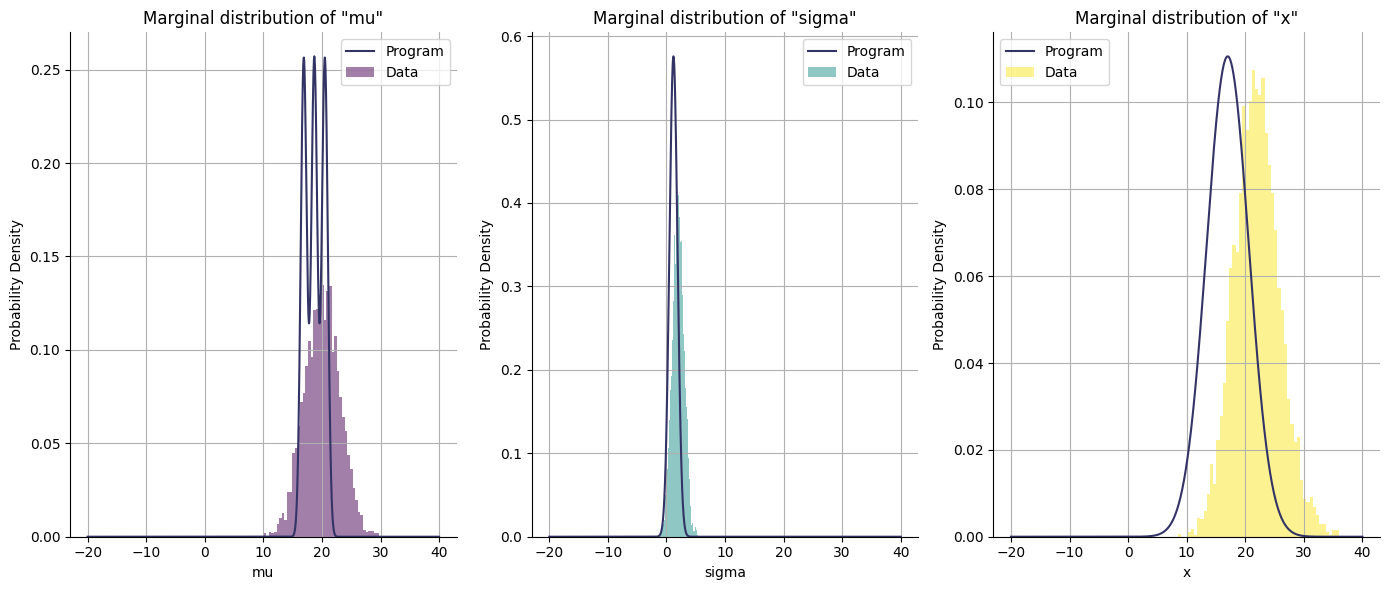

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm


# Define the range for the uniform distribution
x = np.linspace(-20, 40, 3000)
x = torch.tensor(x)

# Assuming data_var_list is defined
#data_var_list = ['a', 'b']  # Example list, replace with your actual list
colormap = cm.get_cmap('viridis', len(data_var_list))
colors = [colormap(i) for i in range(len(data_var_list))]


# Create a figure with subplots
fig, axs = plt.subplots(1, len(data_var_list), figsize=(14, 6))

# If there's only one element in data_var_list, axs will not be an array, so we need to handle that case
if len(data_var_list) == 1:
    axs = [axs]

# Loop through each element in data_var_list and create a subplot
for i, var in enumerate(data_var_list):
    color = colors[i]
    axs[i].plot(x, [get_mixture_pdf([xi], var=var) for xi in x], label='Program', color='#333366')   
    axs[i].hist([pair[i] for pair in data], bins=50, density=True, alpha=0.5, color=color, label='Data')
    axs[i].set_title(f'Marginal distribution of "{var}"')
    axs[i].set_xlabel(f"{var}")
    axs[i].set_ylabel("Probability Density")
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
output_dist.gm.cov


<bound method GaussianMix.cov of pi: [0.016843234464, 0.0059627655360000005, 0.176960312208, 0.062646687792, 0.160117077744, 0.056683922256000004, 0.043067454815999995, 0.015246545184000001, 0.012792320623999999, 0.004528679376, 0.130481522656, 0.046192477344000005, 0.198281338944, 0.070194661056] mu: [array([ 1.24500000e+03, -1.18974200e+05, -1.02318744e+07]), array([ 1.24500000e+03, -1.18974200e+05, -1.02318553e+07]), array([ 8.08420000e+03, -7.82376600e+05, -6.72844808e+07]), array([ 8.08420000e+03, -7.82376600e+05, -6.72844617e+07]), array([ 7.96800e+02, -7.54988e+04, -6.49299e+06]), array([ 7.9680000e+02, -7.5498800e+04, -6.4929709e+06]), array([ 9.1300000e+02, -8.6770200e+04, -7.4623304e+06]), array([ 9.1300000e+02, -8.6770200e+04, -7.4623113e+06]), array([ 3.17060000e+03, -3.05757400e+05, -2.62952296e+07]), array([ 3.17060000e+03, -3.05757400e+05, -2.62952105e+07]), array([ 2.98800000e+03, -2.88045200e+05, -2.47719804e+07]), array([ 2.98800000e+03, -2.88045200e+05, -2.47719613e+

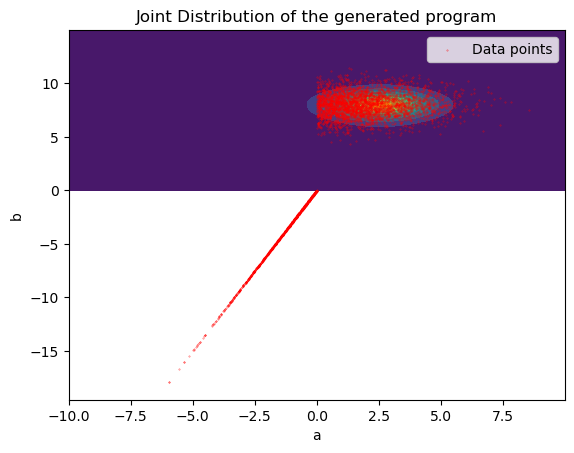

In [ ]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D

def get_mixture_pdf1(x, y):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf([x, y], mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf

def get_mixture_pdf(point, data_var_list = data_var_list):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        


x, y = np.mgrid[-10:10:.01, 0:15:.01]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos, data_var_list=['a', 'b']))
ax2.scatter([pair[0] for pair in data], [pair[1] for pair in data], color = 'red', alpha = 0.7, s = 0.1, label = 'Data points')
ax2.set_title("Joint Distribution of the generated program")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.legend()

In [ ]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[100000000,0],[0,0]], allow_singular=True)
var.pdf([1,1])

3.98942278406721e-05